# Main imports and code

In [2]:
# check which gpu we're using
!nvidia-smi

Mon Mar  3 13:24:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:21:00.0  On |                  N/A |
| 24%   37C    P8             30W /  250W |      80MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install pandas

In [4]:
!pip install googletrans==4.0.0-rc1

In [5]:
!pip install simpletransformers
!pip install tensorboardx
!pip install nltk

In [6]:
!pip install torch

In [7]:
!pip install tensorflow

In [8]:
!pip install setuptools

In [9]:
from urllib import request
import pandas as pd
import logging
import torch
from torch import nn 
from collections import Counter
from ast import literal_eval
from googletrans import Translator # NOTE: Run in your venv: `pip install googletrans==4.0.0-rc1``
from tqdm import tqdm

In [10]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [11]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

2025-03-03 13:25:04.639592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741008304.803616 3419269 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741008304.851889 3419269 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 13:25:05.231545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found GPU at: /device:GPU:0


I0000 00:00:1741008324.170091 3419269 gpu_device.cc:2022] Created device /device:GPU:0 with 9721 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:21:00.0, compute capability: 7.5


# Fetch Don't Patronize Me! data manager module

In [12]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [13]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [14]:
from dont_patronize_me import DontPatronizeMe

In [15]:
dpm = DontPatronizeMe('data/train/', '.')

In [16]:
dpm.load_task1()

# Load paragraph IDs

In [17]:
trids = pd.read_csv('data/train/train_semeval_parids-labels.csv')
teids = pd.read_csv('data/dev/dev_semeval_parids-labels.csv')

In [18]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [19]:
data=dpm.train_task1_df

In [20]:
data

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


# Rebuild training set

In [21]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):
  parid = str(trids.par_id[idx])
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })

  trdf1 = pd.DataFrame(rows)

In [22]:
trdf1  # training and validation data

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0
8373,8383,hopeless,You have to see it from my perspective . I may...,0


In [23]:
# Split the training data into training and validation sets
# (This needs to be done before downsampling and augmentation)
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(trdf1, test_size=0.1, random_state=40)
print("Number of pcl in training set: ", Counter(train_df.label))
print("Number of pcl in validation set: ", Counter(eval_df.label))

Number of pcl in training set:  Counter({0: 6816, 1: 721})
Number of pcl in validation set:  Counter({0: 765, 1: 73})


## Data sampling
Only downsample training data (not including validation)

In [24]:
# Downsample negative instances
# this is to handle the class imbalance, and ensures positive to negative ratio is 1:2
pcldf = train_df[train_df.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,train_df[train_df.label==0][:npos*2]])

In [25]:
training_set1

,par_id,community,text,label
565,9342,in-need,"Wow , all five of these women are so dedicated...",1
534,7349,homeless,The charity has a number of success stories wh...,1
147,4693,disabled,The games are also in line with Emperor Gaza I...,1
459,6241,homeless,A lot of people just don ? ? ? t recognize the...,1
566,1115,hopeless,""""""" We have to sit down , dialogue with those ...",1
...,...,...,...,...
1362,632,poor-families,""""""" These children are from poor families , th...",0
6796,6642,poor-families,"Child abuse , including sexual abuse , occurs ...",0
6821,6670,disabled,"Speaking to Citi News , Interim chairman for t...",0
3039,2497,vulnerable,""""""" The con artists were reaching the widow th...",0


In [26]:
print("After downsampling ...")
print("Number of pcl in training set: ", Counter(training_set1.label))
print("Training set size: ", len(training_set1))

After downsampling ...
Number of pcl in training set:  Counter({0: 1442, 1: 721})
Training set size:  2163


## Simple Baseline Models
### 1. BoW with Logistic Regression

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

In [28]:
# Feature extraction (BoW)
vectorizer = CountVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(training_set1.text)
X_dev = vectorizer.transform(eval_df.text)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, training_set1.label)

# Evaluate
dev_preds = model.predict(X_dev)
f1 = f1_score(eval_df.label, dev_preds)
print(f"F1 Score (BoW + Logistic Regression): {f1}")

F1 Score (BoW + Logistic Regression): 0.37333333333333335


### 2. TF-IDF with Support Vector Machine

In [29]:
# Feature extraction (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(training_set1.text)
X_dev = vectorizer.transform(eval_df.text)

# Train SVM
model = LinearSVC()
model.fit(X_train, training_set1.label)

# Evaluate
dev_preds = model.predict(X_dev)
f1 = f1_score(eval_df.label, dev_preds)
print(f"F1 Score (TF-IDF + SVM): {f1}")

F1 Score (TF-IDF + SVM): 0.39473684210526316


## Data augmentation the training set
### 1. Translating into another language, and back to english
NOTE: I've commented this out because the augmentation only has to be done once and I've kept the augmented (translated) training data in `out_data/translated_data.csv`
Also note: We are only augmenting the training data (which includes the validation data, but not test data)

In [30]:
training_set1   # After downsampling

,par_id,community,text,label
565,9342,in-need,"Wow , all five of these women are so dedicated...",1
534,7349,homeless,The charity has a number of success stories wh...,1
147,4693,disabled,The games are also in line with Emperor Gaza I...,1
459,6241,homeless,A lot of people just don ? ? ? t recognize the...,1
566,1115,hopeless,""""""" We have to sit down , dialogue with those ...",1
...,...,...,...,...
1362,632,poor-families,""""""" These children are from poor families , th...",0
6796,6642,poor-families,"Child abuse , including sexual abuse , occurs ...",0
6821,6670,disabled,"Speaking to Citi News , Interim chairman for t...",0
3039,2497,vulnerable,""""""" The con artists were reaching the widow th...",0


In [31]:
# import time
# import os
# from deep_translator import GoogleTranslator
# import numpy as np

# def back_translate_text(text, src_lang='en', intermediate_lang='fr'):
#     translated = GoogleTranslator(source=src_lang, target=intermediate_lang).translate(text)
#     back_translated = GoogleTranslator(source=intermediate_lang, target=src_lang).translate(translated)
#     return back_translated

# # Apply back-translation to a percentage of the DataFrame
# def back_translate_dataframe(df, text_column='text', src_lang='en', intermediate_lang='fr', augment_frac=0.4, batch_size=50, delay=2):
#     positive_samples = df[df.label == 1].copy()

#     if len(positive_samples) == 0:
#         print("No positive samples found in the DataFrame.")
#         return pd.DataFrame()
    
#     num_positive_samples = len(positive_samples)
#     num_augment = int(num_positive_samples * augment_frac)
#     augment_indices = np.random.choice(num_positive_samples, size=num_augment, replace=False)
    
#     augment_indices = np.sort(augment_indices)
    
#     new_augmented_data = []
    
#     for i in tqdm(range(0, len(augment_indices), batch_size)):
#         batch_indices = augment_indices[i:i + batch_size]
#         batch = positive_samples.iloc[batch_indices]
        
#         augmented_batch = batch.copy()
#         augmented_batch[text_column] = batch[text_column].apply(
#             lambda x: back_translate_text(x, src_lang=src_lang, intermediate_lang=intermediate_lang)
#         )
        
#         new_augmented_data.append(augmented_batch)
        
#         print(f"Processed {i + batch_size} rows...")
#         time.sleep(delay)  # Add delay between batches
    

#     new_augmented_df = pd.concat(new_augmented_data)
    
#     return new_augmented_df

# augmented_translate_df = back_translate_dataframe(training_set1[1000:], text_column='text', augment_frac=0.4, batch_size=10, delay=2)
# # augmented_translate_df.to_csv('translated_data_added.csv', index=False)
# augmented_translate_df.to_csv('translated_data_added.csv', mode='a', header=False, index=False)

# print(training_set1.head())
# print(augmented_translate_df.head())

### 2. Sentence shuffling

In [32]:
# TODO: Implement sentence shuffling
import random
import nltk
from nltk.tokenize import sent_tokenize
import numpy as np
nltk.download('punkt')

# Only need to run the nltk download lines once
# nltk.download('punkt')
# nltk.download('punkt_tab')

# Function to shuffle sentences in a text
def shuffle_sentences(text):
    # Tokenises text into sentences
    sentences = sent_tokenize(text)
    print(sentences)
    
    # Shuffle the sentences
    random.shuffle(sentences)
    
    # Reconstructs the shuffled text
    shuffled_text = ' '.join(sentences)
    return shuffled_text

def augment_with_sentence_shuffling(df, text_column, augment_frac):
    augmented_df = df.copy()
    augment_size = int(len(df) * augment_frac)
    augment_indices = np.random.choice(df.index, size=augment_size, replace=False)
    
    # Apply sentence shuffling to the selected rows
    for idx in augment_indices:
        if idx in augmented_df.index:
            original_text = augmented_df.at[idx, text_column]
            augmented_df.at[idx, text_column] = shuffle_sentences(original_text)
        else:
            print(f"Index {idx} not found in DataFrame.")
    
    return augmented_df


augmented_shuffle_df = augment_with_sentence_shuffling(training_set1, text_column='text', augment_frac=0.5)

# Saves augmented data
augmented_shuffle_df.to_csv('our_data/shuffled_data.csv', mode='a', header=False, index=False)

# Display some of the original and augmented data
print(training_set1.head())
print(augmented_shuffle_df.head())



[nltk_data] Downloading package punkt to /homes/rg921/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/homes/rg921/nltk_data'
    - '/vol/bitbucket/rg921/coursework/nlp-pcl-analysis/venv/nltk_data'
    - '/vol/bitbucket/rg921/coursework/nlp-pcl-analysis/venv/share/nltk_data'
    - '/vol/bitbucket/rg921/coursework/nlp-pcl-analysis/venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


### Data augmentation experiment
Use the baseline model (RoBERTa-base) to do this experiment, and use the best data augmentation for the ensemble learning.

In [33]:
# TODO: 
# 1. Train and evaluate the model on the original data
# 2. Train and evaluate the model on the translated data
# 3. Train and evaluate the model on the sentence shuffled data
# 4. Train and evaluate the model on the translated + sentence shuffled data
# 5. Compare performances

## Data Sampling Techniques

### Weighted Sampling

In [34]:
import pandas as pd
import numpy as np


# Step 1: Assigning Weights Based on Community and Text Length
def assign_weights(df, text_column='text', community_column='community'):
    # Assign weight based on community (higher weight for certain categories)
    community_weights = {
        'in-need': 3, 'homeless': 2, 'refugee': 2, 'vulnerable': 1.5, 
        'poor-families': 1.5, 'disabled': 1.5, 'hopeless': 1, 'migrant': 1, 'women': 1
    }
    
    # Add weights based on the community
    df['community_weight'] = df[community_column].map(community_weights).fillna(1)
    
    # Assign additional weight based on the text length (longer text has higher weight)
    df['text_weight'] = df[text_column].apply(lambda x: len(x) / 100)  # Normalize length by 100
    
    # Combine the weights (you can adjust this combination logic)
    df['weights'] = df['community_weight'] * df['text_weight']
    
    # Normalize weights to sum to 1
    df['weights'] /= df['weights'].sum()
    
    return df

# Apply weight assignment
df = assign_weights(training_set1)

# Step 2: Resample All Rows Based on Their Weights
def weighted_resample(df, num_samples=None):
    if num_samples is None:
        num_samples = len(df)
    
    # Resample the entire dataset based on weights
    sampled_indices = np.random.choice(df.index, size=num_samples, replace=True, p=df['weights'])
    return df.loc[sampled_indices]

# Resample the dataset (with replacement based on the weights)
resampled_df = weighted_resample(df)

# Step 3: Save the resampled data to CSV
resampled_df.to_csv('our_data/resampled_weighted_data.csv', mode='w', header=True, index=False)

# Display some of the resampled data
print("Resampled DataFrame:")
print(resampled_df[['par_id', 'community', 'text', 'weights']])


Resampled DataFrame:
     par_id      community                                               text  \
7069   6940       disabled  """ According to the Third and Fifth Schedules...   
4653   4271        in-need  First you have to stop the bleeding , and then...   
419    9250  poor-families  In June this year , Gates launched a campaign ...   
5256   4921       hopeless  "In another part of her commentary , she said ...   
1817   1146          women  But League Central is also conscious of the ba...   
...     ...            ...                                                ...   
2929   2375        refugee  The government 's message has been loud and cl...   
5744   5462        in-need  Detention should only be used as a last resort...   
71     9036       hopeless  The sound of the bulldozers coming ever closer...   
7118   6999  poor-families  What seems like a convenient arrangement for e...   
236    1188        in-need  """ It was n't uncommon for Johannah to hear t...   

      

# Rebuild test set (Task 1)

In [35]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):
  parid = str(teids.par_id[idx])
  #print(parid)
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })


In [36]:
len(rows)

2094

In [37]:
official_dev_df = pd.DataFrame(rows)

In [38]:
print(official_dev_df)

     par_id   community                                               text  \
0      4046    hopeless  We also know that they can benefit by receivin...   
1      1279     refugee  Pope Francis washed and kissed the feet of Mus...   
2      8330     refugee  Many refugees do n't want to be resettled anyw...   
3      4063     in-need  "Budding chefs , like "" Fred "" , "" Winston ...   
4      4089    homeless  "In a 90-degree view of his constituency , one...   
...     ...         ...                                                ...   
2089  10462    homeless  The sad spectacle , which occurred on Saturday...   
2090  10463     refugee  """ The Pakistani police came to our house and...   
2091  10464    disabled  "When Marie O'Donoghue went looking for a spec...   
2092  10465       women  "Sri Lankan norms and culture inhibit women fr...   
2093  10466  vulnerable  He added that the AFP will continue to bank on...   

      label  
0         1  
1         1  
2         1  
3      

In [39]:
official_dev_df.sample(frac=1)

,par_id,community,text,label
1848,10196,in-need,"Additionally , if investors decide they need a...",0
276,8467,homeless,Mr Vanderpuije called police on the reporters ...,0
1137,9411,in-need,""""""" The boxing community is wonderful at helpi...",0
713,8948,refugee,President Kenyatta is in Brussels to discuss t...,0
1095,9365,women,""""""" But I agree with them , """" say some women ...",0
...,...,...,...,...
1486,9802,migrant,"3,100 Europe bound migrants drown",0
1099,9369,homeless,As well as a resource centre that provides emp...,0
597,8818,vulnerable,"In early 2017 , the then Finance Minister Ravi...",0
1296,9580,vulnerable,The fire broke out around 4 a.m. on the 38th f...,0


# Ensemble learning

## Base models training

### Set Up

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from tqdm import tqdm
import numpy as np

/vol/bitbucket/rg921/coursework/nlp-pcl-analysis/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
# Define a PyTorch Dataset class
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=256, return_tensors="pt")
        inputs = {key: value.squeeze(0) for key, value in inputs.items()}
        return inputs, torch.tensor(label, dtype=torch.long)

In [42]:
# Hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 2e-5

train_texts = training_set1['text'].tolist()
train_labels = training_set1['label'].tolist()

val_texts = eval_df['text'].tolist()
val_labels = eval_df['label'].tolist()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
def load_model_and_tokenizer(model_name):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    return model, tokenizer

In [44]:
def train_and_validate_model(model, tokenizer):

    train_dataset = TextDataset(tokenizer, train_texts, train_labels)
    val_dataset = TextDataset(tokenizer, val_texts, val_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    
    best_f1 = 0
    patience = 2
    counter = 0
    
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            inputs = {key: value.to(device) for key, value in inputs.items()}
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        scheduler.step()
        print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")
    
        # Validation phase
        model.eval()
        predictions, true_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = {key: value.to(device) for key, value in inputs.items()}
                labels = labels.to(device)
                
                outputs = model(**inputs)
                preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
                predictions.extend(preds)
                true_labels.extend(labels.cpu().numpy())
        
        f1 = f1_score(true_labels, predictions, average='binary')
        print(f"Validation F1 Score: {f1:.4f}\n")
        
        # Early stopping check
        if f1 > best_f1:
            best_f1 = f1
            counter = 0
        else:
            counter += 1
            if epoch != num_epochs - 1 and counter >= patience:
                print("Early stopping triggered")
                break
    
    return predictions, true_labels

### Base model 1: RoBERTa-base

In [45]:
# Train baseline model 1: roberta-base
model1, tokenizer1 = load_model_and_tokenizer("FacebookAI/roberta-base")
predictions1, true_labels1 = train_and_validate_model(model1, tokenizer1)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 68/68 [00:32<00:00,  2.09it/s]


Epoch 1 Loss: 0.5347
Validation F1 Score: 0.4444



Epoch 2: 100%|██████████| 68/68 [00:31<00:00,  2.15it/s]


Epoch 2 Loss: 0.3109
Validation F1 Score: 0.4775



Epoch 3: 100%|██████████| 68/68 [00:31<00:00,  2.14it/s]


Epoch 3 Loss: 0.2767
Validation F1 Score: 0.4770



Epoch 4: 100%|██████████| 68/68 [00:31<00:00,  2.13it/s]


Epoch 4 Loss: 0.2721
Validation F1 Score: 0.4770

Early stopping triggered


### Base model 2: DistilBERT

In [46]:
# Train baseline model 2: DistilBERT
model2, tokenizer2 = load_model_and_tokenizer("distilbert/distilbert-base-uncased")
predictions2, true_labels2 = train_and_validate_model(model2, tokenizer2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]


Epoch 1 Loss: 0.5383
Validation F1 Score: 0.4305



Epoch 2: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


Epoch 2 Loss: 0.3624
Validation F1 Score: 0.4372



Epoch 3: 100%|██████████| 68/68 [00:16<00:00,  4.03it/s]


Epoch 3 Loss: 0.3445
Validation F1 Score: 0.4261



Epoch 4: 100%|██████████| 68/68 [00:16<00:00,  4.04it/s]


Epoch 4 Loss: 0.3431
Validation F1 Score: 0.4261

Early stopping triggered


### Base model 3: BERT base uncased

In [47]:
# # Train baseline model 3: ALBERT base v2
model3, tokenizer3 = load_model_and_tokenizer("bert-base-uncased")
predictions3, true_labels3 = train_and_validate_model(model3, tokenizer3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 68/68 [00:33<00:00,  2.03it/s]


Epoch 1 Loss: 0.5535
Validation F1 Score: 0.4000



Epoch 2: 100%|██████████| 68/68 [00:32<00:00,  2.08it/s]


Epoch 2 Loss: 0.3843
Validation F1 Score: 0.3976



Epoch 3: 100%|██████████| 68/68 [00:32<00:00,  2.08it/s]


Epoch 3 Loss: 0.3622
Validation F1 Score: 0.4153



Epoch 4: 100%|██████████| 68/68 [00:32<00:00,  2.08it/s]


Epoch 4 Loss: 0.3534
Validation F1 Score: 0.4216



Epoch 5: 100%|██████████| 68/68 [00:32<00:00,  2.07it/s]


Epoch 5 Loss: 0.3514
Validation F1 Score: 0.4216



Epoch 6: 100%|██████████| 68/68 [00:32<00:00,  2.08it/s]


Epoch 6 Loss: 0.3528
Validation F1 Score: 0.4216

Early stopping triggered


## Ensemble learning methods

### Set up

In [48]:
# Stack the predictions from all 3 models
X_meta = np.column_stack([predictions1, predictions2, predictions3])

assert np.array_equal(true_labels1, true_labels2)
assert np.array_equal(true_labels1, true_labels3)
y_meta = true_labels1

X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(X_meta, y_meta, test_size=0.3, random_state=42)

### Majority voting (Hard voting)

In [49]:
class HardVotingClassifier():

    def predict(self, all_predictions):

        return [1 if sum(predictions) > 1 else 0 for predictions in all_predictions]
    
voting_model = HardVotingClassifier()

predictions_hard_voting = voting_model.predict(X_val_meta)

f1 = f1_score(y_val_meta, predictions_hard_voting)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4545


### Logical AND

In [50]:
class LogicalAndClassifier():

    def predict(self, all_predictions):

        return np.all(all_predictions == 1, axis=1).astype(int)

logical_and_model = LogicalAndClassifier()

predictions_logical_and = logical_and_model.predict(X_val_meta)

# Evaluate performance
f1 = f1_score(y_val_meta, predictions_logical_and)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4906


### Stacking (Meta-learning)

In [51]:
from sklearn.linear_model import LogisticRegression

# Train the meta-model (stacker)
meta_model = LogisticRegression(class_weight='balanced', random_state=42)
meta_model.fit(X_train_meta, y_train_meta)

predictions_stacking = meta_model.predict(X_val_meta)

f1 = f1_score(y_val_meta, predictions_stacking)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4533


### Choose ensemble learning technique

In [52]:
ensemble_model = logical_and_model

# Prepare deliverables

In [53]:
from torch.amp import autocast

def get_baseline_model_predictions(model, tokenizer, df, batch_size=16):
    model.eval()

    texts = df['text'].tolist()
    
    all_preds = []

    with torch.no_grad():
        # Process texts in smaller batches to save memory
        for start_idx in range(0, len(texts), batch_size):
            batch_texts = texts[start_idx:start_idx + batch_size]
 
            encodings = tokenizer(batch_texts, truncation=True, padding=True, return_tensors="pt", max_length=512)

            inputs = {key: value.to(device) for key, value in encodings.items()}

            # Use mixed precision to reduce memory usage
            with autocast('cuda'):
                outputs = model(**inputs)
                preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
                
            all_preds.extend(preds)

    return all_preds

## Predict on the official dev set

In [54]:
# Generate predictions for the official dev set from all 3 models
predictions_dev_1 = get_baseline_model_predictions(model1, tokenizer1, official_dev_df)
predictions_dev_2 = get_baseline_model_predictions(model2, tokenizer2, official_dev_df)
predictions_dev_3 = get_baseline_model_predictions(model3, tokenizer3, official_dev_df)

X_dev_meta = np.column_stack([predictions_dev_1, predictions_dev_2, predictions_dev_3])

final_predictions_dev = ensemble_model.predict(X_dev_meta)

In [55]:
# Calculate F1 score for the stacked model
true_labels_dev = official_dev_df['label'].tolist()
f1 = f1_score(true_labels_dev, final_predictions_dev, average='binary')
print(f"Final F1 Score for Stacked Model: {f1:.4f}")

Final F1 Score for Stacked Model: 0.4828


In [56]:
# Write predictions into a .txt file
with open('outputs/dev.txt', 'w') as file:
    for predictions in final_predictions_dev:
        file.write(f"{predictions}\n")

## Predict on the official test set

In [57]:
df = pd.read_csv('data/test/task4_test.tsv', sep='\t')
df.columns = ['par_id', 'art_id', 'keyword', 'country_code', 'text']
df.par_id = df.par_id.astype(str)
print(df.head())

  par_id      art_id     keyword country_code  \
0    t_1  @@16397324       women           pk   
1    t_2  @@16257812     migrant           ca   
2    t_3   @@3509652     migrant           gb   
3    t_4    @@477506  vulnerable           ca   
4    t_5   @@1797863       women           tz   

                                                text  
0  In most poor households with no education chil...  
1  The real question is not whether immigration i...  
2  In total , the country 's immigrant population...  
3  Members of the church , which is part of Ken C...  
4  To ensure that " Priority Agriculture Programm...  


In [58]:
rows = [] # will contain par_id and text
for idx in range(len(df)):
  parid = str(df.par_id[idx])
  data = df.loc[df.par_id == parid]
  # select row from original dataset to retrieve `text`
  keyword = data.loc[df.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
  })

In [59]:
len(rows)

3831

In [60]:
official_test_df = pd.DataFrame(rows)

In [61]:
print(official_test_df)

      par_id      community                                               text
0        t_1          women  In most poor households with no education chil...
1        t_2        migrant  The real question is not whether immigration i...
2        t_3        migrant  In total , the country 's immigrant population...
3        t_4     vulnerable  Members of the church , which is part of Ken C...
4        t_5          women  To ensure that " Priority Agriculture Programm...
...      ...            ...                                                ...
3826  t_3893        migrant  In a letter dated Thursday to European Commiss...
3827  t_3894  poor-families  They discovered that poor families with health...
3828  t_3895        migrant  She married at 19 , to Milan ( Emil ) Badovina...
3829  t_3896      immigrant  The United Kingdom is n't going to devolve int...
3830  t_3897  poor-families  This moral battle informed the recent defectio...

[3831 rows x 3 columns]


In [62]:
# Generate predictions for the official test set from all 3 models
predictions_test_1 = get_baseline_model_predictions(model1, tokenizer1, official_test_df)
predictions_test_2 = get_baseline_model_predictions(model2, tokenizer2, official_test_df)
predictions_test_3 = get_baseline_model_predictions(model3, tokenizer3, official_test_df)

X_test_meta = np.column_stack([predictions_test_1, predictions_test_2, predictions_test_3])

final_predictions_test = meta_model.predict(X_test_meta)

In [63]:
# Write predictions into a .txt file
with open('outputs/test.txt', 'w') as file:
    for predictions in final_predictions_test:
        file.write(f"{predictions}\n")

## Analysis

### How does the length of the input sequence impact the model performance?

  Length Bin  F1-Score
0       0-50  0.500000
1     51-100  0.476190
2    101-200  0.507692
3    201-500  0.471074
4       500+  0.473684


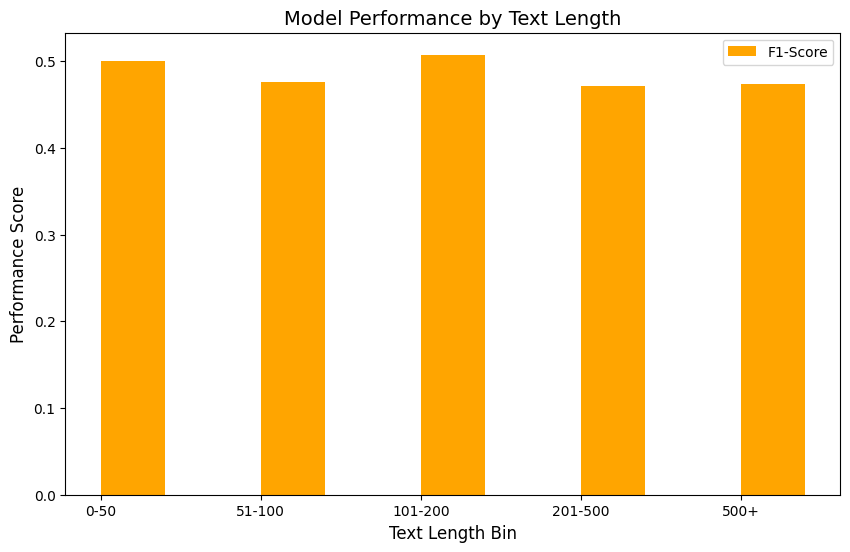

In [97]:
import matplotlib.pyplot as plt

# Compute text length
official_dev_df['text_length'] = official_dev_df['text'].astype(str).apply(len)

# Define bins for text length
bins = [0, 50, 100, 200, 500, np.inf]
labels = ['0-50', '51-100', '101-200', '201-500', '500+']
official_dev_df['length_bin'] = pd.cut(official_dev_df['text_length'], bins=bins, labels=labels, right=False)

# Evaluate performance per length bin
results = []
for bin_label in labels:
    subset = official_dev_df[official_dev_df['length_bin'] == bin_label].copy()

    if not subset.empty:
        subset_predictions1 = get_baseline_model_predictions(model1, tokenizer1, subset)
        subset_predictions2 = get_baseline_model_predictions(model2, tokenizer2, subset)
        subset_predictions3 = get_baseline_model_predictions(model3, tokenizer3, subset)
        X_meta = np.column_stack([subset_predictions1, subset_predictions2, subset_predictions3])
        
        subset.loc[:, 'predicted_label'] = ensemble_model.predict(X_meta)

        f1 = f1_score(subset['label'], subset['predicted_label'])
        results.append({'Length Bin': bin_label, 'F1-Score': f1})

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(10, 6))

bar_width = 0.4  

x = np.arange(len(results_df['Length Bin']))

plt.bar(x + bar_width/2, results_df['F1-Score'], width=bar_width, color='orange', label='F1-Score')

plt.xlabel("Text Length Bin", fontsize=12)
plt.ylabel("Performance Score", fontsize=12)
plt.title("Model Performance by Text Length", fontsize=14)
plt.xticks(x, results_df['Length Bin'])
plt.legend()

plt.show()
